# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Corn/train",
    label_mode="categorical",
    class_names=['Corn Gray leaf spot','Corn healthy','Corn leaf blight','Corn rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Corn/valid",
    label_mode="categorical",
    class_names=['Corn Gray leaf spot','Corn healthy','Corn leaf blight','Corn rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 7665 files belonging to 4 classes.
==========================Validation Data====================
Found 1855 files belonging to 4 classes.


In [5]:
# All images will be rescaled by 1./255.and augmented
train_datagen = ImageDataGenerator(rescale = 1.0/256.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/Corn/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/Corn/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 7665 images belonging to 4 classes.
Found 1855 images belonging to 4 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Mon May 29 16:24:23 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.03                 Driver Version: 532.03       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   55C    P0               32W /  N/A|   5856MiB /  6144MiB |     10%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling With Augmentation

## MobileNetV2 Model 1

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Corn_MobileNetV2_model1_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define DIY Model
MobileNetV2_model = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 2,586,948
Trainable params: 2,552,836
Non-

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_1 = MobileNetV2_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
384/384 [==============================] - ETA: 0s - loss: 0.5104 - accuracy: 0.8789
Epoch 1: val_accuracy improved from -inf to 0.87817, saving model to Corn_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Augmented\assets


384/384 [==============================] - 105s 246ms/step - loss: 0.5104 - accuracy: 0.8789 - val_loss: 0.4084 - val_accuracy: 0.8782 - lr: 0.0010
Epoch 2/100
384/384 [==============================] - ETA: 0s - loss: 0.2064 - accuracy: 0.9275
Epoch 2: val_accuracy improved from 0.87817 to 0.91429, saving model to Corn_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Augmented\assets


384/384 [==============================] - 87s 225ms/step - loss: 0.2064 - accuracy: 0.9275 - val_loss: 0.2679 - val_accuracy: 0.9143 - lr: 0.0010
Epoch 3/100
384/384 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 0.9438
Epoch 3: val_accuracy did not improve from 0.91429
384/384 [==============================] - 72s 186ms/step - loss: 0.1678 - accuracy: 0.9438 - val_loss: 1.0694 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 4/100
384/384 [==============================] - ETA: 0s - loss: 0.1497 - accuracy: 0.9504
Epoch 4: val_accuracy did not improve from 0.91429
384/384 [==============================] - 74s 192ms/step - loss: 0.1497 - accuracy: 0.9504 - val_loss: 0.8947 - val_accuracy: 0.8086 - lr: 0.0010
Epoch 5/100
384/384 [==============================] - ETA: 0s - loss: 0.1357 - accuracy: 0.9511
Epoch 5: val_accuracy improved from 0.91429 to 0.92237, saving model to Corn_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Augmented\assets


384/384 [==============================] - 93s 242ms/step - loss: 0.1357 - accuracy: 0.9511 - val_loss: 0.2242 - val_accuracy: 0.9224 - lr: 0.0010
Epoch 6/100
384/384 [==============================] - ETA: 0s - loss: 0.1398 - accuracy: 0.9529
Epoch 6: val_accuracy did not improve from 0.92237
384/384 [==============================] - 77s 199ms/step - loss: 0.1398 - accuracy: 0.9529 - val_loss: 0.2555 - val_accuracy: 0.8550 - lr: 0.0010
Epoch 7/100
384/384 [==============================] - ETA: 0s - loss: 0.1349 - accuracy: 0.9533
Epoch 7: val_accuracy did not improve from 0.92237
384/384 [==============================] - 76s 196ms/step - loss: 0.1349 - accuracy: 0.9533 - val_loss: 0.5107 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 8/100
384/384 [==============================] - ETA: 0s - loss: 0.1455 - accuracy: 0.9500
Epoch 8: val_accuracy improved from 0.92237 to 0.92830, saving model to Corn_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Augmented\assets


384/384 [==============================] - 92s 239ms/step - loss: 0.1455 - accuracy: 0.9500 - val_loss: 0.1749 - val_accuracy: 0.9283 - lr: 0.0010
Epoch 9/100
384/384 [==============================] - ETA: 0s - loss: 0.1325 - accuracy: 0.9564
Epoch 9: val_accuracy did not improve from 0.92830
384/384 [==============================] - 77s 200ms/step - loss: 0.1325 - accuracy: 0.9564 - val_loss: 0.8578 - val_accuracy: 0.6372 - lr: 0.0010
Epoch 10/100
384/384 [==============================] - ETA: 0s - loss: 0.1311 - accuracy: 0.9516
Epoch 10: val_accuracy did not improve from 0.92830
384/384 [==============================] - 74s 192ms/step - loss: 0.1311 - accuracy: 0.9516 - val_loss: 1.1261 - val_accuracy: 0.6987 - lr: 0.0010
Epoch 11/100
384/384 [==============================] - ETA: 0s - loss: 0.1301 - accuracy: 0.9530
Epoch 11: val_accuracy did not improve from 0.92830
384/384 [==============================] - 76s 198ms/step - loss: 0.1301 - accuracy: 0.9530 - val_loss: 4.7201 

INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Augmented\assets


384/384 [==============================] - 91s 236ms/step - loss: 0.0804 - accuracy: 0.9710 - val_loss: 0.1375 - val_accuracy: 0.9499 - lr: 1.0000e-04
Epoch 16/100
384/384 [==============================] - ETA: 0s - loss: 0.0747 - accuracy: 0.9726
Epoch 16: val_accuracy improved from 0.94987 to 0.95472, saving model to Corn_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Augmented\assets


384/384 [==============================] - 90s 232ms/step - loss: 0.0747 - accuracy: 0.9726 - val_loss: 0.1223 - val_accuracy: 0.9547 - lr: 1.0000e-04
Epoch 17/100
384/384 [==============================] - ETA: 0s - loss: 0.0703 - accuracy: 0.9752
Epoch 17: val_accuracy improved from 0.95472 to 0.97628, saving model to Corn_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Augmented\assets


384/384 [==============================] - 90s 234ms/step - loss: 0.0703 - accuracy: 0.9752 - val_loss: 0.0698 - val_accuracy: 0.9763 - lr: 1.0000e-04
Epoch 18/100
384/384 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 0.9795
Epoch 18: val_accuracy did not improve from 0.97628
384/384 [==============================] - 76s 196ms/step - loss: 0.0608 - accuracy: 0.9795 - val_loss: 0.0751 - val_accuracy: 0.9752 - lr: 1.0000e-04
Epoch 19/100
384/384 [==============================] - ETA: 0s - loss: 0.0654 - accuracy: 0.9765
Epoch 19: val_accuracy did not improve from 0.97628
384/384 [==============================] - 102s 265ms/step - loss: 0.0654 - accuracy: 0.9765 - val_loss: 0.1292 - val_accuracy: 0.9526 - lr: 1.0000e-04
Epoch 20/100
384/384 [==============================] - ETA: 0s - loss: 0.0571 - accuracy: 0.9803
Epoch 20: val_accuracy improved from 0.97628 to 0.98167, saving model to Corn_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Augmented\assets


384/384 [==============================] - 114s 295ms/step - loss: 0.0571 - accuracy: 0.9803 - val_loss: 0.0500 - val_accuracy: 0.9817 - lr: 1.0000e-04
Epoch 21/100
384/384 [==============================] - ETA: 0s - loss: 0.0551 - accuracy: 0.9808
Epoch 21: val_accuracy did not improve from 0.98167
384/384 [==============================] - 72s 188ms/step - loss: 0.0551 - accuracy: 0.9808 - val_loss: 0.0667 - val_accuracy: 0.9774 - lr: 1.0000e-04
Epoch 22/100
384/384 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9812
Epoch 22: val_accuracy did not improve from 0.98167
384/384 [==============================] - 72s 187ms/step - loss: 0.0523 - accuracy: 0.9812 - val_loss: 0.0565 - val_accuracy: 0.9795 - lr: 1.0000e-04
Epoch 23/100
384/384 [==============================] - ETA: 0s - loss: 0.0499 - accuracy: 0.9816
Epoch 23: val_accuracy did not improve from 0.98167
384/384 [==============================] - 76s 199ms/step - loss: 0.0499 - accuracy: 0.9816 - va

INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Augmented\assets


384/384 [==============================] - 89s 231ms/step - loss: 0.0472 - accuracy: 0.9830 - val_loss: 0.0488 - val_accuracy: 0.9822 - lr: 1.0000e-04
Epoch 25/100
384/384 [==============================] - ETA: 0s - loss: 0.0489 - accuracy: 0.9825
Epoch 25: val_accuracy did not improve from 0.98221
384/384 [==============================] - 73s 189ms/step - loss: 0.0489 - accuracy: 0.9825 - val_loss: 0.0485 - val_accuracy: 0.9811 - lr: 1.0000e-04
Epoch 26/100
384/384 [==============================] - ETA: 0s - loss: 0.0440 - accuracy: 0.9842
Epoch 26: val_accuracy did not improve from 0.98221
384/384 [==============================] - 70s 182ms/step - loss: 0.0440 - accuracy: 0.9842 - val_loss: 0.0663 - val_accuracy: 0.9779 - lr: 1.0000e-04
Epoch 27/100
384/384 [==============================] - ETA: 0s - loss: 0.0414 - accuracy: 0.9838
Epoch 27: val_accuracy improved from 0.98221 to 0.98544, saving model to Corn_MobileNetV2_model1_Based_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model1_Based_Augmented\assets


384/384 [==============================] - 89s 231ms/step - loss: 0.0414 - accuracy: 0.9838 - val_loss: 0.0573 - val_accuracy: 0.9854 - lr: 1.0000e-04
Epoch 28/100
384/384 [==============================] - ETA: 0s - loss: 0.0444 - accuracy: 0.9845
Epoch 28: val_accuracy did not improve from 0.98544
384/384 [==============================] - 71s 185ms/step - loss: 0.0444 - accuracy: 0.9845 - val_loss: 0.0475 - val_accuracy: 0.9838 - lr: 1.0000e-04
Epoch 29/100
384/384 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9847
Epoch 29: val_accuracy did not improve from 0.98544
384/384 [==============================] - 72s 188ms/step - loss: 0.0388 - accuracy: 0.9847 - val_loss: 0.0690 - val_accuracy: 0.9757 - lr: 1.0000e-04
Epoch 30/100
384/384 [==============================] - ETA: 0s - loss: 0.0362 - accuracy: 0.9873
Epoch 30: val_accuracy did not improve from 0.98544
384/384 [==============================] - 70s 183ms/step - loss: 0.0362 - accuracy: 0.9873 - val

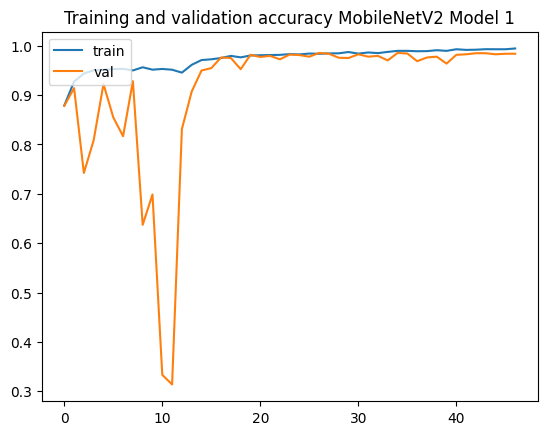

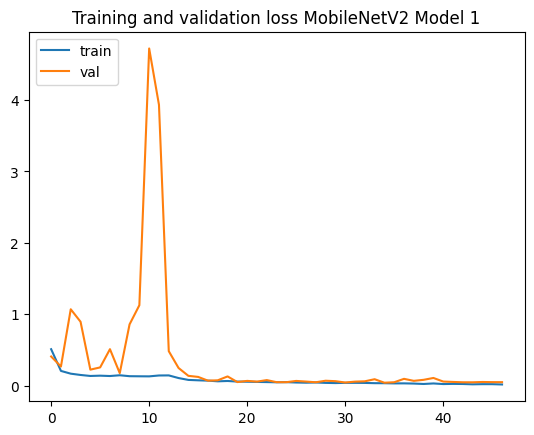

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_1.history['accuracy' ]
val_acc  = history_MobileNetV2_model_1.history['val_accuracy' ]
loss     = history_MobileNetV2_model_1.history['loss' ]
val_loss = history_MobileNetV2_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 1')
plt.legend(['train', 'val'], loc='upper left')

## MobileNetV2 Model 2

In [6]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Corn_MobileNetV2_model2_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [7]:
# Define DIY Model
MobileNetV2_model_2 = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 2,586,948
Trainable params: 2,552,836
Non-

In [8]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_2 = MobileNetV2_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
384/384 [==============================] - ETA: 0s - loss: 0.3161 - accuracy: 0.8874
Epoch 1: val_accuracy improved from -inf to 0.31590, saving model to Corn_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


384/384 [==============================] - 121s 289ms/step - loss: 0.3161 - accuracy: 0.8874 - val_loss: 11.7040 - val_accuracy: 0.3159 - lr: 0.0010
Epoch 2/100
384/384 [==============================] - ETA: 0s - loss: 0.1930 - accuracy: 0.9332
Epoch 2: val_accuracy did not improve from 0.31590
384/384 [==============================] - 57s 148ms/step - loss: 0.1930 - accuracy: 0.9332 - val_loss: 17.9053 - val_accuracy: 0.3078 - lr: 0.0010
Epoch 3/100
384/384 [==============================] - ETA: 0s - loss: 0.1657 - accuracy: 0.9399
Epoch 3: val_accuracy did not improve from 0.31590
384/384 [==============================] - 57s 148ms/step - loss: 0.1657 - accuracy: 0.9399 - val_loss: 7.3314 - val_accuracy: 0.2960 - lr: 0.0010
Epoch 4/100
384/384 [==============================] - ETA: 0s - loss: 0.1555 - accuracy: 0.9457
Epoch 4: val_accuracy did not improve from 0.31590
384/384 [==============================] - 54s 142ms/step - loss: 0.1555 - accuracy: 0.9457 - val_loss: 13.9521 

INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


384/384 [==============================] - 69s 179ms/step - loss: 0.1436 - accuracy: 0.9500 - val_loss: 3.5137 - val_accuracy: 0.4539 - lr: 0.0010
Epoch 6/100
384/384 [==============================] - ETA: 0s - loss: 0.1411 - accuracy: 0.9556
Epoch 6: val_accuracy improved from 0.45391 to 0.57035, saving model to Corn_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


384/384 [==============================] - 71s 183ms/step - loss: 0.1411 - accuracy: 0.9556 - val_loss: 2.4788 - val_accuracy: 0.5704 - lr: 0.0010
Epoch 7/100
384/384 [==============================] - ETA: 0s - loss: 0.1225 - accuracy: 0.9564
Epoch 7: val_accuracy did not improve from 0.57035
384/384 [==============================] - 57s 148ms/step - loss: 0.1225 - accuracy: 0.9564 - val_loss: 7.1829 - val_accuracy: 0.3181 - lr: 0.0010
Epoch 8/100
384/384 [==============================] - ETA: 0s - loss: 0.1196 - accuracy: 0.9585
Epoch 8: val_accuracy improved from 0.57035 to 0.67385, saving model to Corn_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


384/384 [==============================] - 71s 185ms/step - loss: 0.1196 - accuracy: 0.9585 - val_loss: 3.2258 - val_accuracy: 0.6739 - lr: 0.0010
Epoch 9/100
384/384 [==============================] - ETA: 0s - loss: 0.1260 - accuracy: 0.9554
Epoch 9: val_accuracy did not improve from 0.67385
384/384 [==============================] - 57s 148ms/step - loss: 0.1260 - accuracy: 0.9554 - val_loss: 1.5362 - val_accuracy: 0.6496 - lr: 0.0010
Epoch 10/100
384/384 [==============================] - ETA: 0s - loss: 0.1083 - accuracy: 0.9613
Epoch 10: val_accuracy improved from 0.67385 to 0.71914, saving model to Corn_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


384/384 [==============================] - 71s 184ms/step - loss: 0.1083 - accuracy: 0.9613 - val_loss: 0.9429 - val_accuracy: 0.7191 - lr: 0.0010
Epoch 11/100
384/384 [==============================] - ETA: 0s - loss: 0.1229 - accuracy: 0.9580
Epoch 11: val_accuracy did not improve from 0.71914
384/384 [==============================] - 59s 153ms/step - loss: 0.1229 - accuracy: 0.9580 - val_loss: 1.8446 - val_accuracy: 0.7148 - lr: 0.0010
Epoch 12/100
384/384 [==============================] - ETA: 0s - loss: 0.1071 - accuracy: 0.9640
Epoch 12: val_accuracy improved from 0.71914 to 0.91806, saving model to Corn_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


384/384 [==============================] - 72s 186ms/step - loss: 0.1071 - accuracy: 0.9640 - val_loss: 0.3000 - val_accuracy: 0.9181 - lr: 0.0010
Epoch 13/100
384/384 [==============================] - ETA: 0s - loss: 0.0958 - accuracy: 0.9671
Epoch 13: val_accuracy did not improve from 0.91806
384/384 [==============================] - 59s 153ms/step - loss: 0.0958 - accuracy: 0.9671 - val_loss: 1.3069 - val_accuracy: 0.7412 - lr: 0.0010
Epoch 14/100
384/384 [==============================] - ETA: 0s - loss: 0.1063 - accuracy: 0.9623
Epoch 14: val_accuracy did not improve from 0.91806
384/384 [==============================] - 60s 155ms/step - loss: 0.1063 - accuracy: 0.9623 - val_loss: 0.3338 - val_accuracy: 0.8916 - lr: 0.0010
Epoch 15/100
384/384 [==============================] - ETA: 0s - loss: 0.1018 - accuracy: 0.9640
Epoch 15: val_accuracy did not improve from 0.91806
384/384 [==============================] - 59s 153ms/step - loss: 0.1018 - accuracy: 0.9640 - val_loss: 3.047

INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


384/384 [==============================] - 74s 192ms/step - loss: 0.0975 - accuracy: 0.9644 - val_loss: 0.1877 - val_accuracy: 0.9385 - lr: 0.0010
Epoch 18/100
384/384 [==============================] - ETA: 0s - loss: 0.0858 - accuracy: 0.9653
Epoch 18: val_accuracy did not improve from 0.93854
384/384 [==============================] - 60s 156ms/step - loss: 0.0858 - accuracy: 0.9653 - val_loss: 1.5274 - val_accuracy: 0.6798 - lr: 0.0010
Epoch 19/100
384/384 [==============================] - ETA: 0s - loss: 0.0817 - accuracy: 0.9699
Epoch 19: val_accuracy did not improve from 0.93854
384/384 [==============================] - 59s 152ms/step - loss: 0.0817 - accuracy: 0.9699 - val_loss: 1.4418 - val_accuracy: 0.6582 - lr: 0.0010
Epoch 20/100
384/384 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9736
Epoch 20: val_accuracy did not improve from 0.93854
384/384 [==============================] - 59s 153ms/step - loss: 0.0811 - accuracy: 0.9736 - val_loss: 0.834

INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


384/384 [==============================] - 73s 190ms/step - loss: 0.0527 - accuracy: 0.9810 - val_loss: 0.1323 - val_accuracy: 0.9509 - lr: 1.0000e-04
Epoch 24/100
384/384 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.9821
Epoch 24: val_accuracy improved from 0.95094 to 0.95580, saving model to Corn_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


384/384 [==============================] - 73s 189ms/step - loss: 0.0488 - accuracy: 0.9821 - val_loss: 0.1452 - val_accuracy: 0.9558 - lr: 1.0000e-04
Epoch 25/100
384/384 [==============================] - ETA: 0s - loss: 0.0453 - accuracy: 0.9843
Epoch 25: val_accuracy improved from 0.95580 to 0.96873, saving model to Corn_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


384/384 [==============================] - 76s 197ms/step - loss: 0.0453 - accuracy: 0.9843 - val_loss: 0.1007 - val_accuracy: 0.9687 - lr: 1.0000e-04
Epoch 26/100
384/384 [==============================] - ETA: 0s - loss: 0.0427 - accuracy: 0.9854
Epoch 26: val_accuracy improved from 0.96873 to 0.96981, saving model to Corn_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


384/384 [==============================] - 74s 192ms/step - loss: 0.0427 - accuracy: 0.9854 - val_loss: 0.0905 - val_accuracy: 0.9698 - lr: 1.0000e-04
Epoch 27/100
384/384 [==============================] - ETA: 0s - loss: 0.0425 - accuracy: 0.9842
Epoch 27: val_accuracy improved from 0.96981 to 0.98005, saving model to Corn_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


384/384 [==============================] - 73s 189ms/step - loss: 0.0425 - accuracy: 0.9842 - val_loss: 0.0559 - val_accuracy: 0.9801 - lr: 1.0000e-04
Epoch 28/100
384/384 [==============================] - ETA: 0s - loss: 0.0425 - accuracy: 0.9840
Epoch 28: val_accuracy did not improve from 0.98005
384/384 [==============================] - 61s 156ms/step - loss: 0.0425 - accuracy: 0.9840 - val_loss: 0.0798 - val_accuracy: 0.9725 - lr: 1.0000e-04
Epoch 29/100
384/384 [==============================] - ETA: 0s - loss: 0.0406 - accuracy: 0.9854
Epoch 29: val_accuracy did not improve from 0.98005
384/384 [==============================] - 61s 159ms/step - loss: 0.0406 - accuracy: 0.9854 - val_loss: 0.0697 - val_accuracy: 0.9768 - lr: 1.0000e-04
Epoch 30/100
384/384 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 0.9859
Epoch 30: val_accuracy improved from 0.98005 to 0.98598, saving model to Corn_MobileNetV2_model2_Based_Augmented


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Corn_MobileNetV2_model2_Based_Augmented\assets


384/384 [==============================] - 76s 198ms/step - loss: 0.0382 - accuracy: 0.9859 - val_loss: 0.0405 - val_accuracy: 0.9860 - lr: 1.0000e-04
Epoch 31/100
384/384 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9877
Epoch 31: val_accuracy did not improve from 0.98598
384/384 [==============================] - 60s 156ms/step - loss: 0.0371 - accuracy: 0.9877 - val_loss: 0.0646 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 32/100
384/384 [==============================] - ETA: 0s - loss: 0.0377 - accuracy: 0.9856
Epoch 32: val_accuracy did not improve from 0.98598
384/384 [==============================] - 61s 158ms/step - loss: 0.0377 - accuracy: 0.9856 - val_loss: 0.0450 - val_accuracy: 0.9833 - lr: 1.0000e-04
Epoch 33/100
384/384 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 0.9873
Epoch 33: val_accuracy did not improve from 0.98598
384/384 [==============================] - 60s 157ms/step - loss: 0.0376 - accuracy: 0.9873 - val

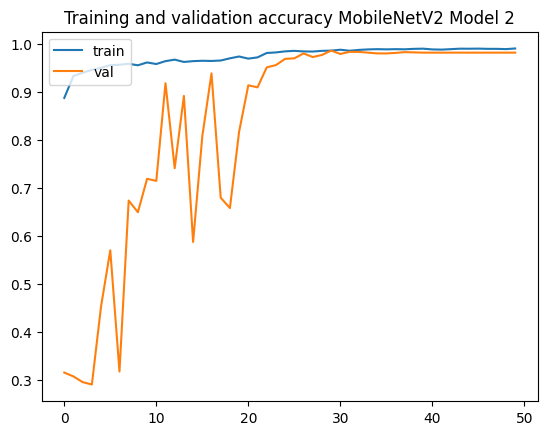

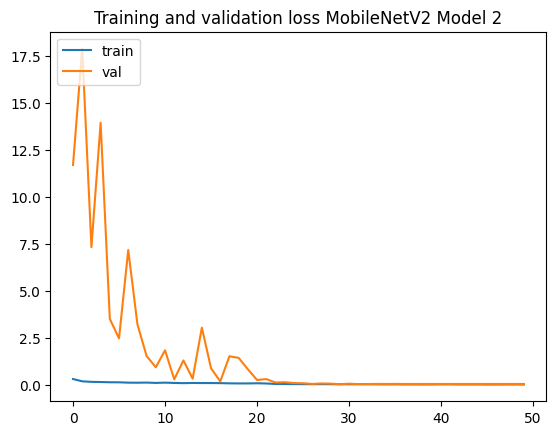

In [9]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_2.history['accuracy' ]
val_acc  = history_MobileNetV2_model_2.history['val_accuracy' ]
loss     = history_MobileNetV2_model_2.history['loss' ]
val_loss = history_MobileNetV2_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')